# Data Exploration

## Load imports.

In [6]:
from gensim.models import KeyedVectors
import gensim.downloader as api
from collections import defaultdict
import heapq
import seaborn as sns
import matplotlib.pyplot as plt

# Make common scripts visible
import sys
sys.path.append('../common/')

from tweet_parser import load_data, create_topic_hashtags_dict, cleanup_tweets
from sentence_utils import remove_stop_words_and_lemmatize
from function_executor import apply_fn_to_list_items_in_dict

## Load the data.

In [2]:
tweets_keyed_by_topic = load_data(20, 'data/')
# Get the hashtags that were used to find the tweets (i.e. the topic indicators)
topic_hashtags_dict = create_topic_hashtags_dict('hashtag_list/')
tweets_keyed_by_topic_cleaned = cleanup_tweets(tweets_keyed_by_topic, topic_hashtags_dict)

## View subset of the tweets for each topic

View uncleaned and cleaned versions.  Cleaned means:
* Removed hashtags that were used to find the tweets as these are topic tags.
* Remove any URLs present in the tweet as these add no value unless they are resolved and summarised.
* Remove any sequence of hashtags at the end of the tweet as these are effectively topic tags.
* For remaining hashtags, remove hash and split into words when camel case or separated by underscores.

In [3]:
num_tweets_to_print = 20

def print_tweets(tweets_keyed_by_topic):
    for topic, tweets in tweets_keyed_by_topic.items():
        print('-------------------- {} --------------------'.format(topic))
        print('')
        for tweet in tweets[:num_tweets_to_print]:
            print('---')
            print(tweet)
            print('---')
        print('') 

print_tweets(tweets_keyed_by_topic)
print_tweets(tweets_keyed_by_topic_cleaned)

-------------------- brexit --------------------

---
Brexit may break Britain’s Tory party https://t.co/MZYrnYb8gA
---
---
Turkey want a religious constitution?!An even better reason to stay in #EU #Brexit #EUref #VoteLeave #LeaveEU  https://t.co/Ieu2J0hfdS
---
---
@Stronger_ln @jeremeycorbyn Don't want Brexit but patronising,insulting campaign ad like that is nuf 2 change my mind if their likes run EU.
---
---
Very odd discussion with an academic who was worried #Brexit would lead to the introduction of student fees. Hello? https://t.co/rQQ0LxWnfL
---
---
"#BREXIT COULD TRIGGER THE COLLAPSE OF FRAGILE #EU" REALLY I SAY GOOD &amp; THAT IS NOT MY RESPONSIBILITY, ALL I WANT IS 4 THE UK TO #voteleave
---
---
Is losing the City of London really a price worth paying for Brexit? | via Telegraph Business https://t.co/VFxpV3srKe
---
---
#Brexit could put UK's #energy links to Europe at risk https://t.co/6hU7yQik7H
---
---
BBC News - EU referendum: Donald Trump backs Brexit https://t.co/09TsNp

## Test Removal of Punctuation

Test the created method that converts a tweet string to a string where punctuation is removed works correctly as Keras will tokenise on spaces only.

In [4]:
tweets_keyed_by_topic_cleaned = apply_fn_to_list_items_in_dict(tweets_keyed_by_topic_cleaned,
                                                               remove_stop_words_and_lemmatize,
                                                               lowercase = False,
                                                               lemmatize = False)

print_tweets(tweets_keyed_by_topic_cleaned)

-------------------- brexit --------------------

---
may break Britain Tory party
---
---
Turkey want religious constitution even better reason stay
---
---
Stronger_ln jeremeycorbyn want patronising insulting campaign ad like nuf 2 change mind likes run EU
---
---
odd discussion academic worried would lead introduction student fees Hello
---
---
COULD TRIGGER COLLAPSE FRAGILE EU REALLY SAY GOOD RESPONSIBILITY WANT 4 UK
---
---
losing City London really price worth paying via Telegraph Business
---
---
could put UK energy links Europe risk
---
---
BBC News EU referendum Donald Trump backs sure support Leave camp want
---
---
.Anand Menon writes PSE could mean UK public agencies
---
---
Donald J. Trump Oi sausage fingers Keep tiny grubby mitts British affairs Focus ballbag instead
---
---
Japan economy tanking UK listen Shinzo Abe via Telegraph Business
---
---
Donald Trump backs says UK better without EU – happened US news Guardian
---
---
Donald Trump opines British politics backs
--

## Case Sensitivity of Pre-Trained Word Vectors

In order to decide whether to lower case all words, we need to examine the pre-trained word embeddings to determine if they were trained on a corpus that was lower cased or not. 

In [5]:
# Test word2vec
word2vec_model = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [6]:
word2vec_model['Donald_Trump']
word2vec_model['European_Union']
word2vec_model['Lindsey_Vonn']
word2vec_model['ski_racer']

# American Climatologist, good indicator of global warming tweet
try:
    word2vec_model['Scott_Denning']
except:
    print('While more prominent people occur in the news, those lesser known do not.')

While more prominent people occur in the news, those lesser known do not.


In [7]:
# Test GloVe
glove_model = api.load("glove-wiki-gigaword-300")

In [8]:
glove_model['olympics']

try:
    glove_model['Donald_Trump']
except:
    print('Glove supports only single lower case words')

try:
    glove_model['Brexit']
except:
    print('Glove supports only single lower case words')

Glove supports only single lower case words
Glove supports only single lower case words


## View top 10 words for each tweet topic

Top 10 in terms of the number of tweets the words occur in.

In [2]:
# Load 100,000 tweets for each topic and lowercase and lemmatize to remove issues of case of plurality
tweets_keyed_by_topic_all = load_data(100000, 'data/')
topic_hashtags_dict = create_topic_hashtags_dict('hashtag_list/')
tweets_keyed_by_topic_all = cleanup_tweets(tweets_keyed_by_topic_all, topic_hashtags_dict)
tweets_keyed_by_topic_all = apply_fn_to_list_items_in_dict(tweets_keyed_by_topic_all,
                                                               remove_stop_words_and_lemmatize,
                                                               lowercase = True,
                                                               lemmatize = True)

In [5]:
word_counts = {}

# For each topic maintain a count of all words encountered
for topic, tweets in tweets_keyed_by_topic_all.items():
    word_counts[topic] = defaultdict(int)
    
    for tweet in tweets:
        tokens = tweet.split()
        for token in tokens:
            word_counts[topic][token] += 1


# Keep top 10 words per topic
capacity = 10
top_words_per_topic = {}

for topic in word_counts.keys():
    top_words = []
    heap_size = 0
    
    for word, count in word_counts[topic].items():
        if heap_size < capacity:
            heapq.heappush(top_words, (count, word))
            heap_size += 1
        else:
            heapq.heappushpop(top_words, (count, word))

    top_words_per_topic[topic] = [heapq.heappop(top_words) for i in range(len(top_words))]

{'brexit': [(4329, 'britain'), (4713, 'david'), (4821, 'via'), (5147, 'news'), (7404, 'leave'), (7617, 'say'), (7646, 'cameron'), (12116, 'vote'), (14345, 'uk'), (19861, 'eu')], 'gaza': [(11085, 'people'), (11801, 'trump'), (12045, 'protest'), (13493, 'killed'), (14229, 'border'), (14367, 'jerusalem'), (14488, 'embassy'), (20503, 'israeli'), (28691, 'palestinian'), (30853, 'israel')], 'fake_news': [(4241, 'new'), (4658, 'like'), (4984, 'medium'), (5452, 'time'), (5713, 'president'), (9347, 'j.'), (9650, 'donald'), (11261, 'news'), (14143, 'cnn'), (22434, 'trump')], 'hurricane_harvey': [(4519, 'path'), (4781, 'coast'), (5162, 'houston'), (6801, 'trump'), (8128, 'stay'), (9571, 'storm'), (10131, '2017'), (11173, 'safe'), (18052, 'texas'), (18406, 'hurricane')], 'winter_olympics': [(5267, 'korea'), (5320, 'opening'), (5670, 'skating'), (5846, 'best'), (7050, 'ceremony'), (7182, 'exo'), (7557, 'olympic'), (8497, 'winter'), (9361, 'team'), (9439, '2018')], 'climate_change': [(4676, 'new'), 

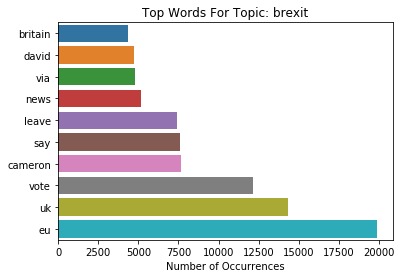

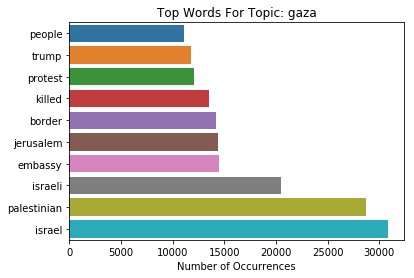

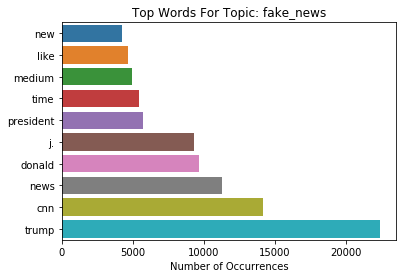

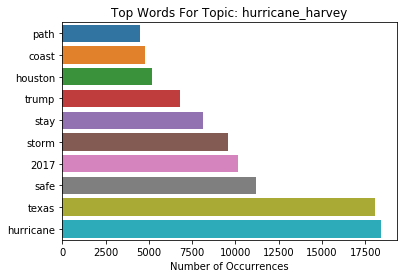

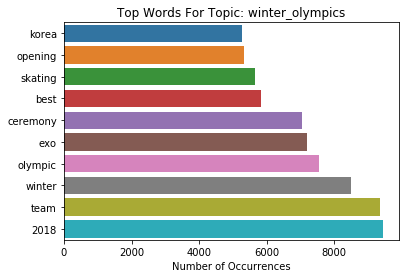

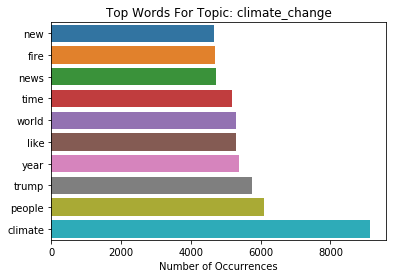

In [9]:
for topic, top_words in top_words_per_topic.items():
    
    x = []
    y = []
    for count, word in top_words:
        y.append(word)
        x.append(count)
    
    plt.figure()
    plt.title('Top Words For Topic: {}'.format(topic))
    plt.xlabel('Number of Occurrences')
    sns.barplot(x=x, y=y)
    plt.show()